**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.


In [2]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [4]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import os
import torch     
from torch import nn                                
from IPython import display

**GETTING THE DATASET:**
- I have used google colab for this project so the process of downloading and reading the data might be different in other platforms. I will use [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/) for this project. The dataset is divided into training and testing and each contains 25000 movie reviews. 

In [6]:
#@ GETTING THE DATASET: 
d2l.DATA_HUB["aclImdb"] = ('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                        '01ada507287d82875905620988597833ad4e0903')                          # Getting the Dataset. 
data_dir = d2l.download_extract("aclImdb", "aclImdb")                                        # Downloading the Dataset. 

**READING THE DATASET:**
- I will read training and test datasets. 

In [7]:
#@ READING THE DATASET: 
def read_imdb(data_dir, is_train):                                   # Reading the Dataset. 
  data, labels = [], []                                              # Initializing Empty Lists. 
  for label in ("pos", "neg"):
    folder_name = os.path.join(data_dir, "train" if is_train else 
                               "test", label)                        # Getting the Folders. 
    for file in os.listdir(folder_name):
      with open(os.path.join(folder_name, file), "rb") as f:
        review = f.read().decode('utf-8').replace("\n", '')
        data.append(review)                                          # Getting the Data. 
        labels.append(1 if label == "pos" else 0)                    # Getting the Labels. 
  return data, labels
#@ IMPLEMENTATION: 
train_data = read_imdb(data_dir, is_train=True)                      # Implementation of Function. 
print(f"Training: {len(train_data[0])}")
for x, y in zip(train_data[0][:3], train_data[1][:3]):
  print("label:", y, "review:", x[0:50])

Training: 25000
label: 1 review: Before Cujo,there was Lucky the devil dog. In 1978
label: 1 review: Robert Standish's novel is about a triangular roma
label: 1 review: That is no criticism of the film, but rather a com


**TOKENIZATION AND VOCABULARY:**
- I will use a word as a token and create a dictionary based on the training dataset. 

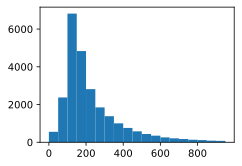

In [8]:
#@ INITIALIZATION OF TOKENIZATION AND VOCABULARY: 
train_tokens = d2l.tokenize(train_data[0], token="word")                  # Tokenizing the Dataset. 
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=["<pad>"])    # Creating a Vocabulary. 
d2l.set_figsize()
d2l.plt.hist([len(line) for line in train_tokens], 
             bins=range(0, 1000, 50));                                    # Plotting Histograms. 

**PADDING TO SAME LENGTH:**
- The histogram presents that the reviews have different lengths so that they cannot be directly combined into minibatches. I will fix the length of each reviews to 500 by truncating or adding unknown indices. 

In [9]:
#@ PADDING TO SAME LENGTH: 
num_steps = 500                                                             # Initializing Length of Sequence. 
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens])      # Padding to Same Length. 
print(train_features.shape)

torch.Size([25000, 500])


**CREATING DATA ITERATOR:**
- I will create a data iterator. Each iteration will return a minibatch of data. 

In [10]:
#@ CREATING DATA ITERATOR: 
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64) # Initializing Training Iterations. 
for X, y in train_iter: 
  print("X:", X.shape, "y:", y.shape)                                          # Inspecting the Data. 
  break
print("Batches:", len(train_iter))                                             # Inspecting the Data. 

X: torch.Size([64, 500]) y: torch.Size([64])
Batches: 391


**PREPARING DATA:**

In [11]:
#@ PREPARING DATA: 
def load_data_imdb(batch_size, num_steps=500):                    # Function for Loading the Data. 
  data_dir = d2l.download_extract("aclImdb", "aclImdb")           # Getting the Data. 
  train_data = read_imdb(data_dir, True)                          # Reading Data for Training. 
  test_data = read_imdb(data_dir, False)                          # Reading Data for Test. 
  train_tokens = d2l.tokenize(train_data[0], token="word")        # Initializing Tokenization. 
  test_tokens = d2l.tokenize(test_data[0], token="word")          # Initializing Tokenization.  
  vocab = d2l.Vocab(train_tokens, min_freq=5)                     # Initializing Vocabulary of Tokens. 
  train_features = torch.tensor([d2l.truncate_pad(
      vocab[line], num_steps, vocab["<pad>"]) for 
      line in train_tokens])                                      # Initializing Training Features. 
  test_features = torch.tensor([d2l.truncate_pad(
      vocab[line], num_steps, vocab["<pad>"]) for 
      line in test_tokens])                                       # Initializing Test Features. 
  train_iter = d2l.load_array((train_features, 
                  torch.tensor(train_data[1])), batch_size)
  test_iter = d2l.load_array((test_features, 
                 torch.tensor(test_data[1])), batch_size, 
                 is_train=False)
  return train_iter, test_iter